# Syntax Repair with Language Models

## Dataset

TODO: Detail data, deepfix cite, explain 
types of errors

#

In [1]:
import pickle
with open("data/syntax-benchmark.pkl", "rb") as fin:
    benchmark = pickle.load(fin)

In [3]:
# number of buggy programs
len(benchmark)

6978

In [10]:
from repair import utils
import tqdm
# distribution of length in terms of tokens
num_tokens = [len(utils.tokenize(b.code)) for b in tqdm.tqdm(benchmark)]


100%|██████████| 6978/6978 [00:14<00:00, 490.58it/s]


Text(0, 0.5, 'Count of cases')

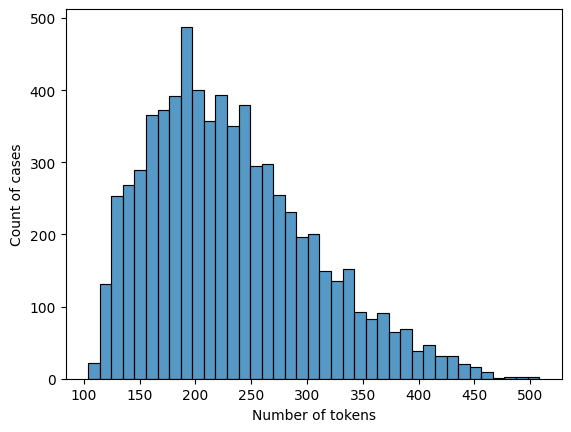

In [17]:
import seaborn as sns
ax = sns.histplot(num_tokens)
ax.set_xlabel("Number of tokens")
ax.set_ylabel("Count of cases")

Text(0, 0.5, 'Count of cases')

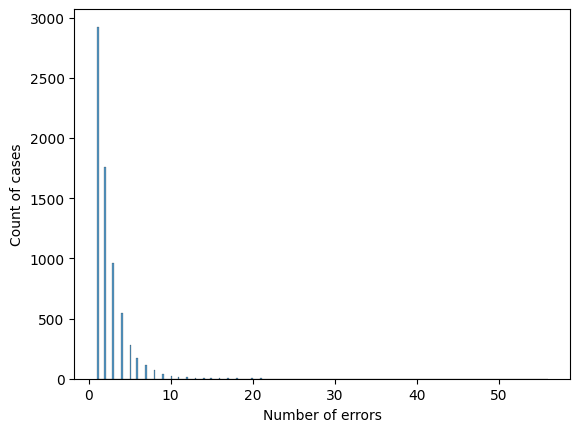

In [18]:
# distribution of number of compile errors
errorcounts = [b.errorcount for b in benchmark]
ax = sns.histplot(errorcounts)
ax.set_xlabel("Number of errors")
ax.set_ylabel("Count of cases")

In [20]:
help(sns.scatterplot)

Help on function scatterplot in module seaborn.relational:

scatterplot(data=None, *, x=None, y=None, hue=None, size=None, style=None, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, markers=True, style_order=None, legend='auto', ax=None, **kwargs)
    Draw a scatter plot with possibility of several semantic groupings.
    
    The relationship between `x` and `y` can be shown for different subsets
    of the data using the `hue`, `size`, and `style` parameters. These
    parameters control what visual semantics are used to identify the different
    subsets. It is possible to show up to three dimensions independently by
    using all three semantic types, but this style of plot can be hard to
    interpret and is often ineffective. Using redundant semantics (i.e. both
    `hue` and `style` for the same variable) can be helpful for making
    graphics more accessible.
    
    See the :ref:`tutorial <relational_tutorial>` for more information.


Text(0, 0.5, 'Number of compilation errors')

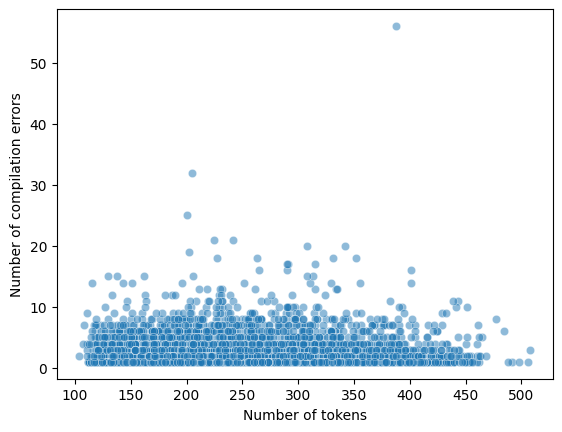

In [26]:
# Relationship between length and errors
ax = sns.scatterplot(x=num_tokens, y=errorcounts, alpha=0.5)
ax.set_xlabel("Number of tokens")
ax.set_ylabel("Number of compilation errors")

In [9]:
# random sample of k compile errors
import random
random.seed(42)
random.shuffle(benchmark)
k = 10
sampled = benchmark[:k]
for i, case in enumerate(sampled):
    print("Sample", i)
    print(case.code)
    print("Error:", case.error)
    print("--------------")

Sample 0
#include<stdio.h>

int main()
{
    //Checking if triangle is invalid, acute, right or obtuse
    int a,b,c;
    int max;
    scanf("%d%d%d",&a,&b,&c);       //input sides 
    if(a>b){
        if(a>c) max=a;
        else max=;
    }
    else{
        if(b>c) max=b;
        else max=c;
    }
    
    if(a+b>c&&b+c>a&&a+c>b){        //Verify if sides are valid
        if(
        
        
    }
    else printf("INVALID");
    return 0;
}
Error: In function ‘main’:
11:18: error: expected expression before ‘;’ token
         else max=;
                  ^
22:5: error: expected expression before ‘}’ token
     }
     ^
22:5: error: expected expression before ‘}’ token
--------------
Sample 1
#include <stdio.h>

int main()
{
    int N,d;
    int arr[31];
    int j,t;
    scanf("%d %d",&d,&N);
    for(j=0;j<30;j++)
    scanf("%d",&arr[j]);
    if(N<=d)
    printf("%d",arr[N]);
    else if(N>d)
    {
        	for(j=0;j<N-d;j++)
          	{
	             for(cnt=1;cnt<=d;cnt++)
	   

# Metrics

In [28]:
bad_simple = "int main( {return 0;}"
ok_simple = "int main() {return 0;}"

In [29]:
utils.gcc_compile(bad_simple)

CompileResult(ok=False, error='/tmp/tmp6tfa42lp.c:1:11: error: expected declaration specifiers or ‘...’ before ‘{’ token\n    1 | int main( {return 0;}\n      |           ^\n', errorcount=1)

In [30]:
utils.gcc_compile(ok_simple)

CompileResult(ok=True, error=None, errorcount=0)

In [35]:
# typically: satisfy oracle (i.e. compiler) but also need to limit edit distance (e.g. deleting everything yields compilable unit)
# token edit distance: standard levenshtein distance but on lexer outputs (better than simple string distance)
utils.token_edit_distance(
    bad_simple,
    ok_simple
)

1.0

In [34]:
from importlib import reload
utils = reload(utils)
# can also use tree edit distance with parse tree that maintains syntax errors
utils.tree_edit_distance(
    bad_simple,
    ok_simple
)

1.0

# Running our benchmark suite

TODO

# Fixing Syntax Errors with Codex

In [36]:
# Reference and explain https://arxiv.org/abs/2208.11640

In [37]:
from repair.engines import codex

In [39]:
import inspect
print(inspect.getsource(codex.CodexEngine))

class CodexEngine(object):
    def __init__(
        self,
        openai_key,
        temperature=0,
        n=1,
        maxtokens=1000,
        stop="###",
        engine="code-davinci-002",
    ):
        openai.key = openai_key
        self.temperature = temperature
        self.maxtokens = maxtokens
        self.n = n
        self.top_p = 1.0
        self.presence_penalty = 0.0
        self.frequency_penalty = 0.0
        self.stop = stop
        self.engine = engine


    def complete(self, prompt, maxtokens=None, n=10):
        try:
            response = openai.Completion.create(
                engine=self.engine,
                prompt=prompt,
                max_tokens=self.maxtokens if maxtokens is None else maxtokens,
                temperature=self.temperature,
                top_p=self.top_p,
                presence_penalty=self.presence_penalty,
                frequency_penalty=self.frequency_penalty,
                stop=self.stop,
                n=n,
           

In [40]:
import inspect
print(inspect.getsource(codex.CodexBaseRepair))

class CodexBaseRepair(object):
    """
    Based on https://beta.openai.com/examples/default-fix-python-bugs
    """
    def __init__(self, *args, **kwargs):
        self.codex = CodexEngine(*args, stop="###", **kwargs)

    def get_prompt(self, code_to_repair, fixed=None):
        # Based on https://beta.openai.com/examples/default-fix-python-bugs
        prompt = """##### Fix bugs in the below code\n"""
        prompt += "### Buggy C\n{buggy}\n\n".format(buggy=code_to_repair)
        prompt += "### Fixed C"
        if fixed is not None:
            prompt += "\n{fixed}\n\n".format(fixed=fixed)

        return prompt

    # def add_repair_from_completion_(self, completion_dict):
    #     # first line corresponds to repair
    #     lines = completion_dict["completion"].strip().split("\n")
    #     repair = lines[0].strip()
    #     completion_dict["repair"] = repair
    #     return completion_dict

    def deduplicate_repairs_(self, repair_dicts):
        unique_repair_dicts = []


In [105]:
from importlib import reload
openai.api_key = None
codex = reload(codex)
codex_base = codex.CodexBaseRepair(openai.api_key)

In [45]:
codex_base.repair("int main({return 0;}")

Skipping exception
Rate limit reached for default-code-davinci-002 in organization org-0dl5WSUnJjIQPKFDFDgy9jNn on tokens per min. Limit: 40000.000000 / min. Current: 100000.000000 / min. Contact support@openai.com if you continue to have issues.


In [65]:
from importlib import reload
codex = reload(codex)
codex_base = codex.CodexBaseRepair(openai.api_key)

In [64]:
codex_base.repair(bad_simple, maxtokens=10)

[{'repair': 'int main() {return 0;}', 'score': -0.11803400770000001}]

### Add error message to improve error localization

In [74]:
print(inspect.getsource(codex.CodexWithErrorInfo))

class CodexWithErrorInfo(CodexBaseRepair):
    """
    Based on https://beta.openai.com/examples/default-fix-python-bugs
    """
    def get_prompt(self, code_to_repair, fixed=None):
        prompt = """//// Fix bugs in the below code\n"""
        prompt += f"/// Buggy C\n{code_to_repair}\n\n"
        comp_result = gcc_compile(code_to_repair)
        error_msg = comp_result.error
        prompt += f"/// Error Message\n{error_msg}\n\n"
        prompt += "/// Fixed C"
        if fixed is not None:
            prompt += "\n{fixed}\n\n".format(fixed=fixed)

        return prompt



In [75]:
benchmark[0]

DeepFixRecord(code_id='prog23416', user_id='user749', problem_id='prob370', code='#include<stdio.h>\n\nint main()\n{\n    //Checking if triangle is invalid, acute, right or obtuse\n    int a,b,c;\n    int max;\n    scanf("%d%d%d",&a,&b,&c);       //input sides \n    if(a>b){\n        if(a>c) max=a;\n        else max=;\n    }\n    else{\n        if(b>c) max=b;\n        else max=c;\n    }\n    \n    if(a+b>c&&b+c>a&&a+c>b){        //Verify if sides are valid\n        if(\n        \n        \n    }\n    else printf("INVALID");\n    return 0;\n}', error='In function ‘main’:\n11:18: error: expected expression before ‘;’ token\n         else max=;\n                  ^\n22:5: error: expected expression before ‘}’ token\n     }\n     ^\n22:5: error: expected expression before ‘}’ token', errorcount=3)

In [69]:
codex = reload(codex)
codex_msg = codex.CodexWithErrorInfo(openai.api_key)

In [70]:
print(codex_msg.get_prompt(bad_simple))

//// Fix bugs in the below code
/// Buggy C
int main( {return 0;}

/// Error Message
/tmp/tmpkn7fm6xa.c:1:11: error: expected declaration specifiers or ‘...’ before ‘{’ token
    1 | int main( {return 0;}
      |           ^


/// Fixed C


In [71]:
codex_msg.repair(bad_simple, maxtokens=100, n=5)

[{'repair': 'int main() {return 0;}\n', 'score': -0.3362135366625}]

### Add few-shots to help show what kind of edits may be needed

In [98]:
codex = reload(codex)
print(inspect.getsource(codex.CodexWithFewShots))

class CodexWithFewShots(CodexBaseRepair):
    """
    Based on https://beta.openai.com/examples/default-fix-python-bugs
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.prompt_helper = CodexWithErrorInfo(*args, **kwargs)

    def get_prompt(self, code: str, **kwargs):
        few_shots = kwargs.get('fewshots', None) or []
        prompt = ""
        for (buggy_shot, fixed_shot) in few_shots:
            prompt += self.prompt_helper.get_prompt(buggy_shot, fixed=fixed_shot)

        prompt += self.prompt_helper.get_prompt(code)
        return prompt



In [99]:
codex_shots = codex.CodexWithFewShots(openai.api_key)

In [103]:
print(codex_shots.repair(bad_simple, fewshots=[('void main(a{}', 'void main(a){}')], n=10))

[{'repair': 'int main() {return 0;}\n', 'score': -0.10833765089846155}]


### How to create an initial example bank?

In [ ]:
# bootstap it yourself
example_bank = codex.generate_basic_example_bank(benchmark, size=100)

### Picking Few-shots

* Fixed (cover some basic examples by hand)
* Random (sample from other programs you have)
* Similar (what does it mean to be similar?)